# Chapter 1: Singular Value Decomposition (SVD)¶

In [1]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from PIL import Image

In [2]:
from platform import python_version
python_version()

'3.6.7'

In [3]:
plot_dir = 'plots'
if not os.path.exists(plot_dir):
    os.mkdir(plot_dir)

## 8. Eigenfaces Example

PCA is applied to a large library of facial images to extract the most dominant correlations between images.

### Download Image Database

Extended Yale Face Database B contains 16128 images of 28 human subjects under 9 poses and 64 illumination conditions.

In this example we use images of 38 individuals (28 from the extended
database, and 10 from the original database) under 9 poses and 64 lighting conditions.

Data is described and can be downloaded here:
http://vision.ucsd.edu/~iskwak/ExtYaleDatabase/ExtYaleB.html"

Download the file (85 MB) from this link, unzip and move the directory 'CroppedYale' and all subdirectories into a directory called 'data':
http://vision.ucsd.edu/extyaleb/CroppedYaleBZip/CroppedYale.zip

Images are separate files in portable gray map (PGM) format.

In [4]:
n_persons = 38
n_poses = 9
n_conditions = 64

In [5]:
data_dir = 'data'
sub_dir = 'CroppedYale'

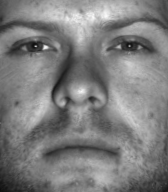

In [6]:
# Test load one train image
filename = 'yaleB01_P00A-005E-10.pgm'
filepath = os.path.join(data_dir, sub_dir, 'yaleB01', filename)
img = Image.open(filepath)
assert img.size == (168, 192)
img

In [7]:
# How to convert image to numpy array
img_array = np.array(img)
img_vector = img_array.flatten()
assert img_array.shape == (192, 168)
assert img_vector.shape == (192*168,)

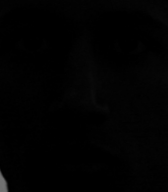

In [8]:
# Some image files are labeled '.bad' - Ignore them
filename = 'yaleB12_P00A-050E-40.pgm.bad'
filepath = os.path.join(data_dir, sub_dir, 'yaleB12', filename)
img = Image.open(filepath)
assert img.size == (168, 192)
img

In [9]:
def get_filenames_and_paths(img_dir, pathname, n=None):
    """Make a dictionary of filenames and paths that
    match the pathname pattern.
    """
    filepaths = {
        os.path.basename(path): path 
        for path in glob.glob(os.path.join(img_dir, pathname))
    }
    if n is not None:
        assert len(filepaths) == n

    return filepaths


def load_images_from_dir(img_dir, pathname, n=None, size=None):
    """Make a dictionary containing the images found in
    the directory with the filenames that match the 
    pathname pattern.
    """
    filepaths = get_filenames_and_paths(img_dir, pathname, n)
    images = {}
    for filename, filepath in filepaths.items():
        img = Image.open(filepath)
        assert img.size == size
        images[filename] = img.copy()
        img.close()

    return images


def load_all_images(img_dirs, pathname, n=None, size=None, 
                    show=False):
    all_images = {}
    for name, img_dir in img_dirs.items():
        images = load_images_from_dir(img_dir, pathname, n=n, 
                                      size=size)
        if show:
            print(f"{img_dir}: {len(images)} images")
        all_images[name] = images
    return all_images

In [10]:
img_dir_names = [
    'yaleB39', 'yaleB01', 'yaleB02', 'yaleB03', 'yaleB04', 
    'yaleB05', 'yaleB06', 'yaleB07', 'yaleB08', 'yaleB09', 
    'yaleB10', 'yaleB11', 'yaleB12', 'yaleB13', 'yaleB15',  # 14 is missing
    'yaleB16', 'yaleB17', 'yaleB18', 'yaleB19', 'yaleB20', 
    'yaleB21', 'yaleB22', 'yaleB23', 'yaleB24', 'yaleB25', 
    'yaleB26', 'yaleB27', 'yaleB28', 'yaleB29', 'yaleB30', 
    'yaleB31', 'yaleB32', 'yaleB33', 'yaleB34', 'yaleB35', 
    'yaleB36', 'yaleB37', 'yaleB38']
img_dirs = {name: os.path.join(data_dir, 'CroppedYale', name)
            for name in img_dir_names}
print(f"Number of image sub-directories: {len(img_dirs)}")
assert len(img_dirs) == n_persons

Number of image sub-directories: 38


In [11]:
# Load all images in different lighting conditions
pathname = 'yale???_P00A????????.pgm'
all_images = load_all_images(img_dirs, pathname, size=(168, 192))
n_images = sum([len(x) for x in all_images.values()])
print(f"{n_images} images loaded")

# Load 'bad' images
#pathname = 'yale*.pgm.bad'
#bad_images = load_all_images(img_dirs, pathname, size=(168, 192))
#n_bad = sum([len(x) for x in bad_images.values()])
#print(f"{n_bad} bad images loaded")

2414 images loaded


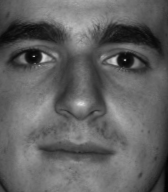

In [12]:
# Images are stored in a dictionary of dictionaries
all_images['yaleB39']['yaleB39_P00A+000E+00.pgm']

In [14]:
names = list(all_images.keys())
assert names == img_dir_names

train_names = names[:36]
test_names = names[36:]
test_names

['yaleB37', 'yaleB38']

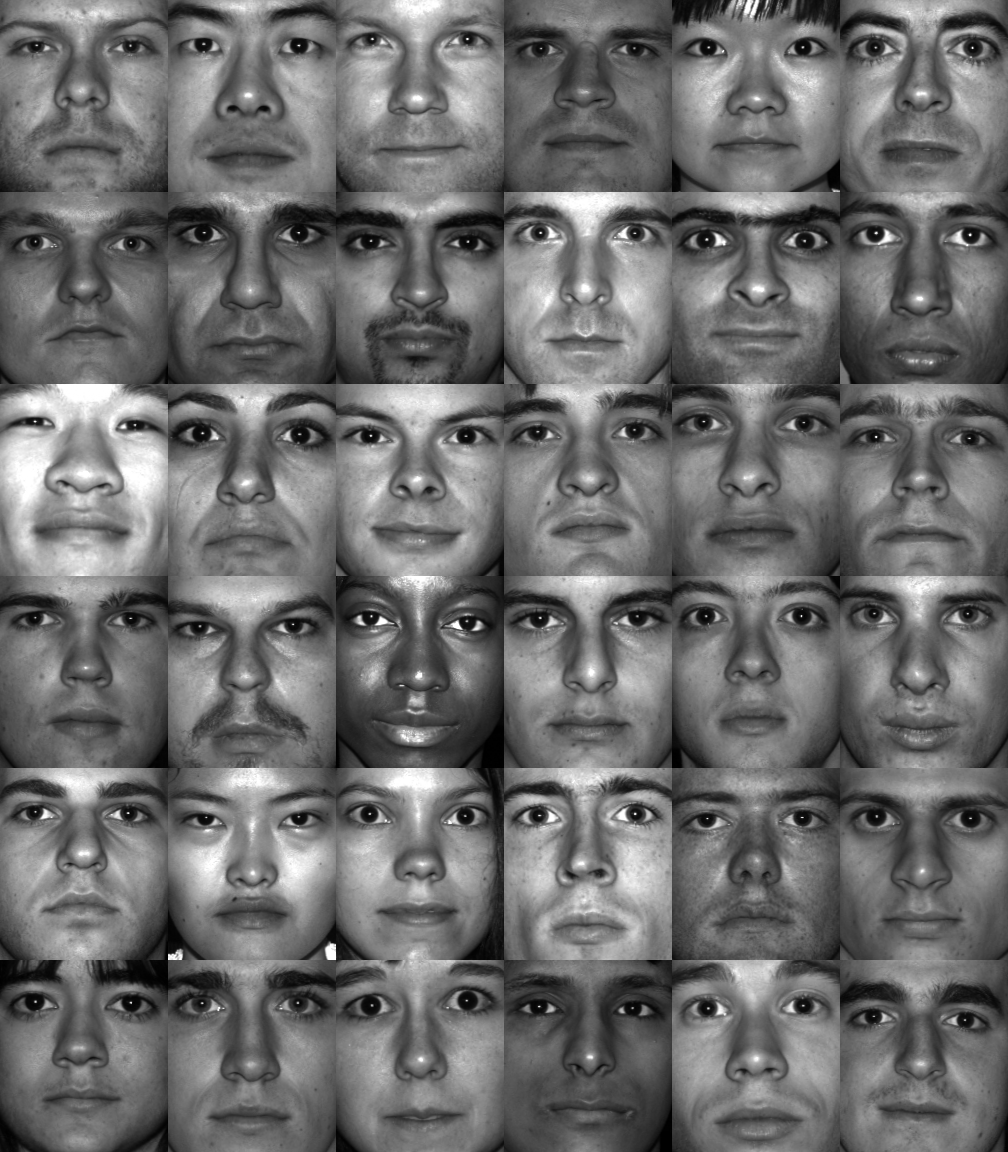

In [15]:
# Make a composite image from images of each face
m = 168
n = 192
all_persons = np.zeros((n*6, m*6))
all_persons.size

row, col = (0, 0)
for i, name in enumerate(sorted(train_names)):
    image = all_images[name][f'{name}_P00A+000E+00.pgm']
    all_persons[row:row+n, col:col+m] = image
    col += m
    if col >= m*6:
        row, col = row + n, 0

composite_faces = Image.fromarray(np.uint8(all_persons))
filename = 'composite.jpg'
filepath = os.path.join(plot_dir, filename)
composite_faces.save(filepath)
composite_faces

In [16]:
# Intensity range
all_persons.min(), all_persons.max()

(0.0, 255.0)

In [17]:
n_images

2414

In [18]:
# Prepare the data matrix of all images
image_size = n*m
x_data = np.zeros((image_size, n_images))
image_filenames = []
for name, images in all_images.items():
    for i, (filename, image) in enumerate(images.items()):
        x_data[:, i] = np.array(image).flatten()
        image_filenames.append(filename)
print(f"X matrix size: {x_data.shape}")
assert x_data.shape == (32256, 2414)

X matrix size: (32256, 2414)
